In [0]:
!wget "https://cdn.skillenza.com/files/5ee0a2e1-bf6d-4173-8244-e75fa2d7bbe2/training.5k.zip"

In [0]:
!wget "https://cdn.skillenza.com/files/7da538a3-4db6-46ea-a4f8-87a21368e5f5/testing.40k.zip"

In [0]:
!unzip "training.5k.zip"

In [0]:
!unzip "testing.40k.zip"

In [0]:
import pandas as pd
import numpy as np

In [0]:
sol = pd.read_csv("/content/training/solution.csv")

In [0]:
sol.category = sol.category -1

In [0]:
sol.groupby(['category']).count()

,id
category,
0,836
1,778
2,831
3,865
4,847
5,843


In [0]:
!mkdir new_dir

In [0]:
import os
import cv2

In [0]:
ORIG_INPUT_Train = "/content/training/training"
BASE_PATH = "/content/new_dir"
ORIG_INPUT_Test ="/content/testing"
 
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
 
VAL_SPLIT = 0.12

In [0]:
from imutils import paths
import random
import shutil
import imutils

In [0]:
from skimage import color

In [0]:
list(paths.list_images(ORIG_INPUT_Train))[0].split(os.path.sep)[-1]

'2343.png'

In [0]:
trainPaths = list(paths.list_images(ORIG_INPUT_Train))
random.seed(42)
random.shuffle(trainPaths)
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]
testPaths = list(paths.list_images(ORIG_INPUT_Test))

In [0]:
len(trainPaths) , len(valPaths), len(testPaths)

(4400, 600, 40000)

In [0]:
str(list(sol[sol.id == int(trainPaths[0].split(os.path.sep)[-1].split(".")[-2])]['category'])[0])

'0'

In [0]:
trainPaths[0]

'/content/training/training/4427.png'

In [0]:
datasets_train_val = [
	( trainPaths, TRAIN_PATH),
	(valPaths, VAL_PATH)
]


for (imagePaths, baseOutput) in datasets_train_val:

	# if the output base output directory does not exist, creating it
	if not os.path.exists(baseOutput):
		os.makedirs(baseOutput)

	# loop over the input image paths
	for inputPath in imagePaths:
		filename = inputPath.split(os.path.sep)[-1]
		label = str(list(sol[sol.id == int(filename.split(".")[-2])]['category'])[0])

		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])

		# if the label output directory does not exist, creating it
		if not os.path.exists(labelPath):
			os.makedirs(labelPath)

		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

In [0]:
os.makedirs(TEST_PATH)
labelPath = os.path.sep.join([TEST_PATH,"test"])
os.makedirs(labelPath)
for inputPath in testPaths:
  filename = inputPath.split(os.path.sep)[-1]	
  p = os.path.sep.join([labelPath, filename])
  shutil.copy2(inputPath,p)

In [0]:
from google.colab.patches import cv2_imshow

In [0]:
def pf(img):
  #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #gray = cv2.medianBlur(img , 5)
  k = cv2.filter2D(img, -1, np.ones((3,3), np.float32)/10)
  k = cv2.morphologyEx(k, cv2.MORPH_OPEN, np.ones((5,6), np.uint8))
  k = color.rgb2gray(k) < color.rgb2gray(k).mean()
  k = k.astype(np.uint8)
  cnts= cv2.findContours(k, cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
  x, y, w, h = cv2.boundingRect(cnts[0])
  img1 = img[y:y+h, x:x+w]
  img1 = cv2.resize(img1,(128, 128))
  img1 = img1.reshape((128,128,-1))
  return img1
  

In [0]:
cv2_imshow(pf(cv2.imread("/content/training/training/1.png")))
cv2.waitKey(0)

In [0]:
pf(cv2.imread("/content/training/training/1.png")).shape

(160, 160, 3)

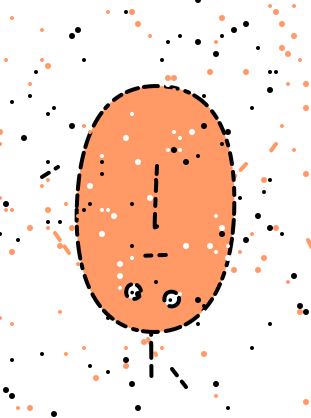

-1

In [0]:
cv2_imshow(cv2.imread("/content/training/training/1.png"))
cv2.waitKey(0)

In [0]:
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
import numpy as np

In [0]:
NUM_EPOCHS = 50
Batch = 32

In [0]:
totalTrain = len(list(paths.list_images(TRAIN_PATH)))
totalVal = len(list(paths.list_images(VAL_PATH)))
totalTest = len(list(paths.list_images(TEST_PATH)))

In [0]:
trainAug = ImageDataGenerator(preprocessing_function= pf)

In [0]:
valAug = ImageDataGenerator(preprocessing_function = pf)
testAug = ImageDataGenerator(preprocessing_function = pf)

In [0]:
trainGen = trainAug.flow_from_directory(
	TRAIN_PATH,
	class_mode="categorical",
	target_size=(128, 128),
	color_mode="grayscale",
	shuffle=True,
	batch_size= Batch)

Found 4400 images belonging to 6 classes.


In [0]:
valGen = valAug.flow_from_directory(
	VAL_PATH,
	class_mode="categorical",
	target_size=(128, 128),
	color_mode="grayscale",
	shuffle=False,
	batch_size=Batch)

Found 600 images belonging to 6 classes.


In [0]:
testGen = testAug.flow_from_directory(
	TEST_PATH,
	class_mode="categorical",
	target_size=(128, 128),
	color_mode="grayscale",
	shuffle=False,
	batch_size=Batch)

Found 40000 images belonging to 1 classes.


In [0]:
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD

In [0]:
def main_block(x, filters, n, strides, dropout):
	# Normal part
	x_res = Conv2D(filters, (3,3), strides=strides, padding="same")(x)
	x_res = BatchNormalization()(x_res)
	x_res = Activation('relu')(x_res)
	x_res = Conv2D(filters, (3,3), padding="same")(x_res)
	# Alternative branch
	x = Conv2D(filters, (1,1), strides=strides)(x)
	# Merge Branches
	x = add([x_res, x])

	for i in range(n-1):
		# Residual conection
		x_res = BatchNormalization()(x)
		x_res = Activation('relu')(x_res)
		x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		# Apply dropout if given
		if dropout: x_res = Dropout(dropout)(x)
		# Second part
		x_res = BatchNormalization()(x_res)
		x_res = Activation('relu')(x_res)
		x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		# Merge branches
		x = add([x, x_res])

	# Inter block part
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	return x

In [0]:
def build_model(input_dims, output_dim, n, k, act= "relu", dropout=None):
  
	# Ensure n & k are correct
  n = (n-4)//6
  # This returns a tensor input to the model
  inputs = Input(shape=(input_dims))

	# Head of the model
  x = Conv2D(16, (3,3), padding="same")(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # 3 Blocks (normal-residual)
  x = main_block(x, 16*k, n, (1,1), dropout) # 0
  x = main_block(x, 32*k, n, (2,2), dropout) # 1
  x = main_block(x, 64*k, n, (2,2), dropout) # 2

  # Final part of the model
  x = AveragePooling2D((8,8))(x)
  x = Flatten()(x)
  x = Dense(32)(x)
  x = Activation('relu')(x)
  x = Dense(output_dim)(x)
  outputs = Activation("softmax")(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model

In [0]:
model = build_model((128,128,1), 6, 22, 4)

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_58 (BatchNo (None, 128, 128, 16) 64          conv2d_67[0][0]                  
__________________________________________________________________________________________________
activation_62 (Activation)      (None, 128, 128, 16) 0           batch_normalization_58[0][0]     
__________________________________________________________________________________________________
conv2d_68 

In [0]:
model.compile(optimizer="adam" , loss="categorical_crossentropy", metrics=['accuracy'])

In [0]:
import keras

In [0]:
#!pip install livelossplot

In [0]:
#from livelossplot import PlotLossesKeras

In [0]:
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // Batch,
	validation_data=valGen,
	validation_steps=totalVal // Batch,
	epochs=NUM_EPOCHS,
  callbacks=[keras.callbacks.ModelCheckpoint(
                  'Model.val-acc={val_acc:.2f}.val-loss={val_loss:.2f}.h5',
                  monitor='val_loss',
                  verbose=0,
                  save_best_only=True)])

Epoch 1/40
137/137 [==============================] - 82s 597ms/step - loss: 1.6222 - acc: 0.2616 - val_loss: 1.4845 - val_acc: 0.2587
Epoch 2/40
137/137 [==============================] - 74s 543ms/step - loss: 1.4533 - acc: 0.2769 - val_loss: 5.9161 - val_acc: 0.2007
Epoch 3/40
137/137 [==============================] - 73s 536ms/step - loss: 1.3739 - acc: 0.3004 - val_loss: 1.7989 - val_acc: 0.2905
Epoch 4/40
137/137 [==============================] - 74s 542ms/step - loss: 1.3391 - acc: 0.3173 - val_loss: 9.8321 - val_acc: 0.2271
Epoch 5/40
137/137 [==============================] - 75s 550ms/step - loss: 1.2871 - acc: 0.3278 - val_loss: 2.4879 - val_acc: 0.1602
Epoch 6/40
137/137 [==============================] - 75s 551ms/step - loss: 1.2381 - acc: 0.3440 - val_loss: 9.2509 - val_acc: 0.1813
Epoch 7/40
137/137 [==============================] - 76s 553ms/step - loss: 1.1946 - acc: 0.3474 - val_loss: 1.3166 - val_acc: 0.2975
Epoch 8/40
137/137 [==============================] - 7

In [0]:
import matplotlib.pyplot as plt

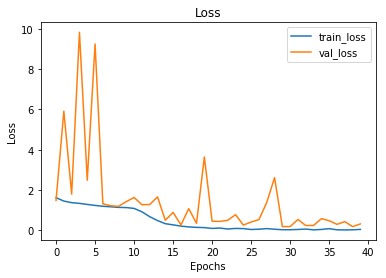

In [0]:
plt.plot(np.arange(0, NUM_EPOCHS), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="best")

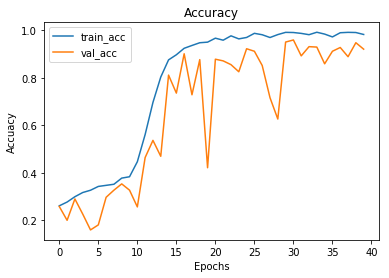

In [0]:
plt.plot(np.arange(0, NUM_EPOCHS), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, NUM_EPOCHS), H.history["val_acc"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuacy")
plt.legend(loc="best")

In [0]:
from keras.models import load_model

In [0]:
model = load_model('/content/Model.val-acc=0.95.val-loss=0.18.h5')

In [0]:
predId = model.predict_generator(testGen,
	steps=(totalTest // Batch))
 

In [0]:
predId = np.argmax(predId, axis=1)

In [0]:
predIds = predId + 1

In [0]:
import glob

In [0]:
names = list(paths.list_images('/content/new_dir/testing'))

In [0]:
clean_name=[]
for name in names:
  filename = name.split(os.path.sep)[-1].split(".")[-2]
  clean_name.append(filename)
  